In [28]:
import os
os.environ['OMP_NUM_THREADS'] = '8'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

data = pd.read_csv('mnist-1.csv', header=None)

label = data.iloc[:, 0].to_numpy() # First column is the label (digits 0-9)
features = data.iloc[:, 1:].to_numpy() # Pixels of the 28x28 image (784 features)

In [29]:
label.shape, features.shape

((6000,), (6000, 784))

In [30]:
class pca:
    def __init__(self, x, n_components=None):
        self.x = x
        self.n_components = n_components
        self.num_samples = x.shape[0]
        self.ori_feat = x.shape[1]
        self.P = None
        self.y = None

    def cov(self, X_meaned):
        self.cov_mat = np.dot(X_meaned.T, X_meaned) / (self.num_samples - 1)
        return self.cov_mat

    def standardization(self, X):
        return X - np.mean(X, axis=0)

    def reduce_feature(self):
        x_meaned = self.standardization(self.x)

        x_cov = self.cov(x_meaned)

        eigen_val, eigen_vec = np.linalg.eig(x_cov)

        sort_index = np.argsort(eigen_val)[::-1]

        sorted_eigenval = eigen_val[sort_index]
        sorted_eigenvector = eigen_vec[:, sort_index]

        if self.n_components:
            sorted_eigenvector = sorted_eigenvector[:, :self.n_components]

        self.P = sorted_eigenvector # projection matrix
        self.y = np.dot(x_meaned, self.P) # transformed data

        return self.y
    
pca_10 = pca(features, 10)
transformed_features = pca_10.reduce_feature()
print(f'The input x has shape {features.shape}, and the transformed x has shape {transformed_features.shape}')
print(f'The sum of the input covariance matrix is {round(np.sum(pca_10.cov_mat), 5)}.')
print(f'The sum of the transformed covariance matrix is {round(np.sum(np.cov(transformed_features.T)).real, 5)}.')

The input x has shape (6000, 784), and the transformed x has shape (6000, 10)
The sum of the input covariance matrix is 1127.90333.
The sum of the transformed covariance matrix is 26.22057.


In [31]:
# compare with PCA from sci-kit learn
from sklearn.decomposition import PCA
pca_sklearn = PCA(n_components=10)
transformed_features_sklearn = pca_sklearn.fit_transform(features)
print(f'The transformed data from the sklearn PCA has shape {transformed_features_sklearn.shape}.')
print(f'The sum of the input covariance matrix is {round(np.sum(np.cov(data.T)).real, 5)}.')
print(f'The sum of the transformed covariance matrix is {round(np.sum(np.cov(transformed_features_sklearn.T)).real, 5)}.')

The transformed data from the sklearn PCA has shape (6000, 10).
The sum of the input covariance matrix is 1127.28197.
The sum of the transformed covariance matrix is 26.22055.


In [32]:
def k_means(x, k=2, epochs=600):
    np.random.seed(42)
    n_samples, n_features = x.shape
    centroids = x[np.random.choice(n_samples, k, replace=False)]
    loss = []
    clusters = [[] for _ in range(k)]

    for epoch in range(epochs):
        new_centroids = np.zeros((k, n_features))
        for i in range(k):
            clusters[i] = []

        # Expectation step
        for i in range(n_samples):
            distances = [np.linalg.norm(x[i] - centroids[j]) for j in range(k)]
            closest_centroid = np.argmin(distances)
            clusters[closest_centroid].append(i)

        # Maximization step
        for i in range(k):
            if clusters[i]:
                new_centroids[i] = np.mean(x[clusters[i]], axis=0)
            else:
                new_centroids[i] = centroids[i]

        # Check for convergence
        if np.allclose(new_centroids, centroids):
            break
        
        epoch_loss = 0
        for i in range(k):
            if clusters[i]:
                epoch_loss += np.sum([np.linalg.norm(x[j] - new_centroids[i])**2 for j in clusters[i]])
        loss.append(epoch_loss)
        centroids = new_centroids

    return clusters, centroids, loss

clusters, centers, loss = k_means(features, k=10)
# Sum of the centroids
print(f'The sum of the centroids is {np.sum(centers)}.')

The sum of the centroids is 1067.5787825267507.


In [33]:
# compare with k-means from sci-kit learn
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42).fit(features)
centers_sklearn = kmeans.cluster_centers_
# Sum of the centroids
print(f'The sum of the centroids from sklearn is {np.sum(centers_sklearn)}.')

The sum of the centroids from sklearn is 1065.557890440527.


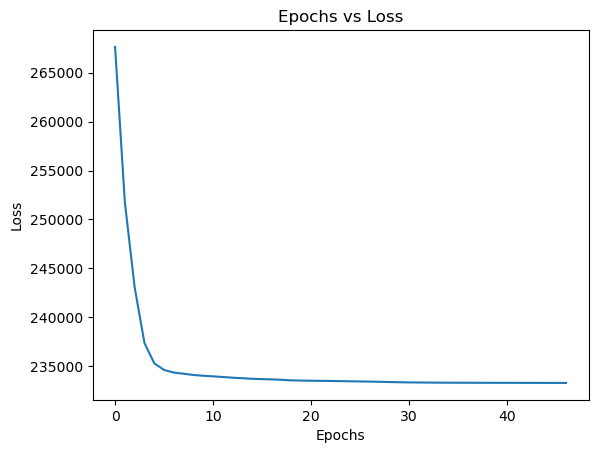

In [34]:
# Plot epochs(number of iteration) vs loss
import matplotlib.pyplot as plt
plt.plot([i for i in range(len(loss))], loss)
plt.title('Epochs vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

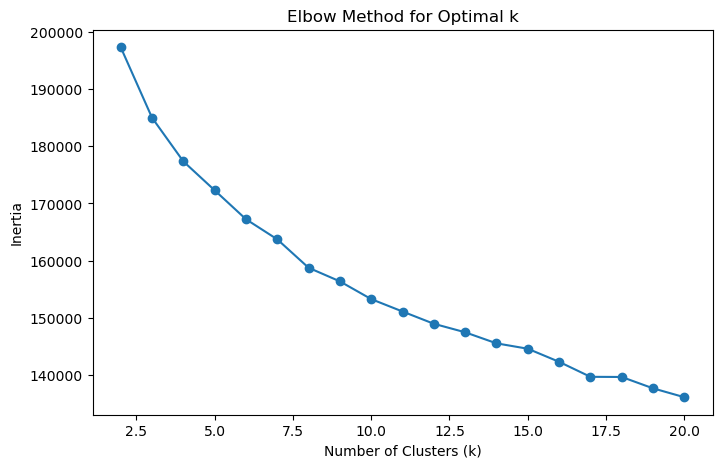

In [35]:
# Split into training and validation sets
X_train = features[:4000]
y_train = label[:4000]
X_val = features[4000:]
y_val = label[4000:]

k_values = range(2, 21)

# Elbow Method
inertia_values = []

# Calculate inertia for a range of k values
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

No clear elbow points using elbow methods, try find optimal K using Silhouette Score

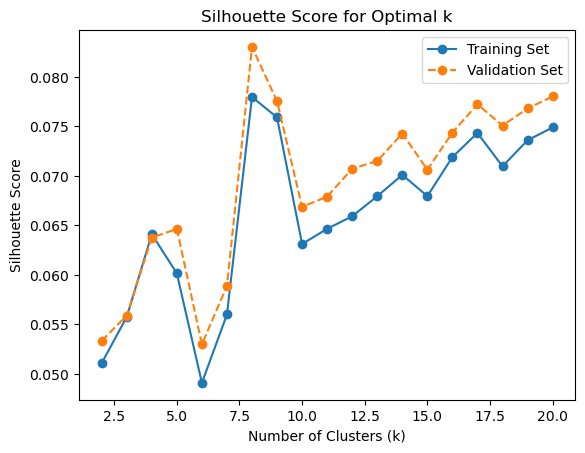

Best k based on silhouette score: 8


In [36]:
silhouette_scores = []
silhouette_scores_val = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train)

    score = silhouette_score(X_train, kmeans.labels_)
    silhouette_scores.append(score)

    val_labels = kmeans.predict(X_val)

    score_val = silhouette_score(X_val, val_labels)
    silhouette_scores_val.append(score_val)
    
best_k_silhouette = k_values[silhouette_scores_val.index(max(silhouette_scores_val))]

plt.figure()
plt.plot(k_values, silhouette_scores, marker='o', label='Training Set')
plt.plot(k_values, silhouette_scores_val, marker='o', label='Validation Set', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.legend()
plt.show()

print(f"Best k based on silhouette score: {best_k_silhouette}") 

In [37]:
def calculate_rbf_kernel(X):
    n = X.shape[0]
    kernel_x = np.zeros((n, n)) 
    sigma = 0

    # Calculate the sum of distances for sigma
    for i in range(n):
        for j in range(n):
            sigma += np.linalg.norm(X[i] - X[j])**2

    sigma_squaredx2 = sigma / (n**2)

    # Calculate the kernel matrix
    for i in range(n):
        for j in range(n):
            kernel_x[i, j] = np.exp(-np.linalg.norm(X[i] - X[j])**2 / (sigma_squaredx2))

    return kernel_x

# Implement kernel k-means with RBF kernel for first 500 samples
rbf_kernel = calculate_rbf_kernel(features[0:500])
clusters, centers, loss = k_means(rbf_kernel, k=5)
print(f'The sum of the centroids is {np.sum(centers)}.')

The sum of the centroids is 949.274433887095.


In [38]:
# compare with k-means from sci-kit learn
kmeans = KMeans(n_clusters=5, random_state=42).fit(rbf_kernel)
centers_sklearn = kmeans.cluster_centers_
print(f'The sum of the centroids is {np.sum(centers_sklearn)}.')

The sum of the centroids is 978.547518401235.


c:\Users\Kheng\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
